## Population in Ireland: Where are we heading to?

### Scenario
Human capital is an important bed rock of any stable economy, a large population means more workers and customers which ultimately boosts a country’s GDP (World101, 2022).
As stated by (Wilmoth, Menozzi and Bassarsky, 2022) world population is expected to peak around 2100 at a level of almost 11 billion. (OECD and UN, 2023) both reported a country requires a birth rate of 2.1 children per woman to maintain a healthy population growth. However, Ireland has recorded a progressive decline in its birth rate since 1970 but were still within a healthy birth rate.

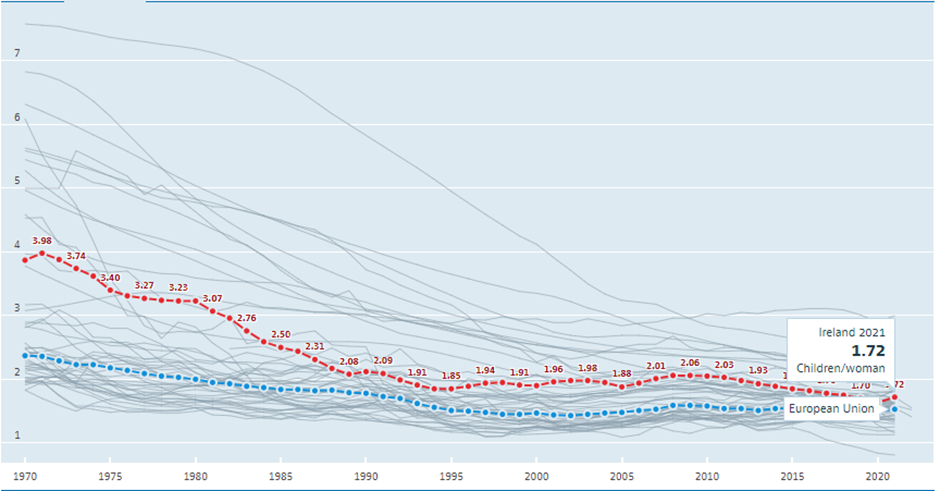

#### Data source
- Independent features: The dataset for this analysis is going to be gotten from the Central Statistics Office (CSO), Ireland. The CSO is responsible for collection, compilation, extraction and dissemination of high-quality data used for analysis of economic and social important topics.

- Dependent feature:

### Approach
At this first stage we will approach the case aiming to fit a Random Forest Regressor Machine Learning model, due to its multiple benefits like low risk of overfitting, easy to determine feature importance and not needing considerable pre-processing work, to name a few.

### Importing libraries

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm



import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
sns.set_style('whitegrid')

### Loading our independent features

In [2]:
df = pd.read_csv('Total Births, Deaths and Marriages Registered.csv')
df.head(-5)

,Statistic Label,Quarter,State,UNIT,VALUE
0,Marriages Registered,1960Q1,State,Number,2987.0
1,Marriages Registered,1960Q2,State,Number,3501.0
2,Marriages Registered,1960Q3,State,Number,5900.0
3,Marriages Registered,1960Q4,State,Number,3106.0
4,Marriages Registered,1961Q1,State,Number,2179.0
...,...,...,...,...,...
4544,Average age of mothers giving birth,2020Q4,State,Number,NaN
4545,Average age of mothers giving birth,2021Q1,State,Number,NaN
4546,Average age of mothers giving birth,2021Q2,State,Number,NaN
4547,Average age of mothers giving birth,2021Q3,State,Number,NaN


### Data dictionary

##### Statistic Label
- Marriages Registered
- Marriage Rate Registered per 1000 Estimated Population
- Deaths Registered
- Death Rate Registered per 1000 Estimated Population
- Deaths of Infants under 1 Year Registered per 1000 Births
- Births Registered
- Birth Rate Registered per 1000 Estimated Population
- Opposite sex marriages
- Same sex marriages
- Civil partnerships
- Births registered that were first births
- Births registered outside marriage
- Opposite sex marriage rate
- Same sex marriage rate
- Civil partnership marriage rate
- Percentage of first births registered
- Percentage of births registered outside marriage
- Average age of mothers giving birth

##### Quarter
Years from 1960 (Q1) to 2023 (Q1); each year has 4 quarters (Q1, Q2, Q3 and Q4).

##### State
- State

##### UNIT
These represents the metric of the next feature (VALUE).
- Number
- %

##### VALUE
Values regarding the Statistic Label feature.

### EDA and data preparation

In [3]:
df.info() # Check the shape and and types of our data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4554 entries, 0 to 4553
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Statistic Label  4554 non-null   object 
 1   Quarter          4554 non-null   object 
 2   State            4554 non-null   object 
 3   UNIT             4554 non-null   object 
 4   VALUE            1826 non-null   float64
dtypes: float64(1), object(4)
memory usage: 178.0+ KB


In [4]:
df.isnull().mean()*100 # Porcentage of missing data

Statistic Label     0.000000
Quarter             0.000000
State               0.000000
UNIT                0.000000
VALUE              59.903382
dtype: float64

In [5]:
df['Statistic Label'].unique() # Check the categories in our Statistic Label.

array(['Marriages Registered',
       'Marriage Rate Registered per 1000 Estimated Population',
       'Deaths Registered',
       'Death Rate Registered per 1000 Estimated Population',
       'Deaths of Infants under 1 Year Registered per 1000 Births',
       'Births Registered',
       'Birth Rate Registered per 1000 Estimated Population',
       'Opposite sex marriages', 'Same sex marriages',
       'Civil partnerships', 'Births registered that were first births',
       'Births registered outside marriage', 'Opposite sex marriage rate',
       'Same sex marriage rate', 'Civil partnership marriage rate',
       'Percentage of first births registered',
       'Percentage of births registered outside marriage',
       'Average age of mothers giving birth'], dtype=object)

Let's confirm that our 'State' feature only has 1 category, and in that case we can drop the feature due that it doesn't add any value to our analysis.

In [6]:
df['State'].unique()

array(['State'], dtype=object)

In [7]:
df.drop(columns='State', inplace=True) # Dropping the 'State' feature.
df.head()

,Statistic Label,Quarter,UNIT,VALUE
0,Marriages Registered,1960Q1,Number,2987.0
1,Marriages Registered,1960Q2,Number,3501.0
2,Marriages Registered,1960Q3,Number,5900.0
3,Marriages Registered,1960Q4,Number,3106.0
4,Marriages Registered,1961Q1,Number,2179.0


Since we are looking for values in numbers and not represented in percentages, we will drop all the rows that has % in our 'UNIT' feature, after performing this task, we can now drop the 'UNIT' feature because we know that we only have values represented in numbers.

In [8]:
df['UNIT'].unique()

array(['Number', '%'], dtype=object)

In [9]:
df = df[df['UNIT'].str.contains('%')==False]
df['UNIT'].unique()

array(['Number'], dtype=object)

In [10]:
df.drop(columns='UNIT', inplace=True)
df.head()

,Statistic Label,Quarter,VALUE
0,Marriages Registered,1960Q1,2987.0
1,Marriages Registered,1960Q2,3501.0
2,Marriages Registered,1960Q3,5900.0
3,Marriages Registered,1960Q4,3106.0
4,Marriages Registered,1961Q1,2179.0


Standardize in lower case letters in a new feature our 'Statistic Label' feature to manage all the categories easier.

In [11]:
df['label_lc'] = df['Statistic Label'].apply(lambda x: ' '.join(x.lower() for x in x.split())) # put everything in lower case
df[['label_lc']].head()

,label_lc
0,marriages registered
1,marriages registered
2,marriages registered
3,marriages registered
4,marriages registered


Since we are analysing the population change per year, we do not need the values per quater, therefore we will remove Q1, Q2, Q3 and Q4 from the Quater column and then we will be able to asign the column as a integer (whole numbers).


In [12]:
df.rename(columns={"Quarter": "year"}, inplace=True)
df.rename(columns={"VALUE": "value"}, inplace=True)

In [13]:
df['year'] = df['year'].str[:-2] # Remove the 2 last characters
df['year']

0       1960
1       1960
2       1960
3       1960
4       1961
        ... 
4549    2022
4550    2022
4551    2022
4552    2022
4553    2023
Name: year, Length: 3289, dtype: object

In [14]:
df['year'] = df['year'].astype(int) # Assign Quarter column as a type integer
df.dtypes

Statistic Label     object
year                 int32
value              float64
label_lc            object
dtype: object

Due to we have a dataset which years are divided per quarter, we need to sum each quarter value into one single row, then, we can remove every category in our 'label_lc' feature that we do not need, we only require the overall value of births, deaths and marriages.

In [15]:
df_group = df.groupby(['year','label_lc'])['value'].sum()
df_group.head(20)

year  label_lc                                                 
1960  average age of mothers giving birth                              0.0
      birth rate registered per 1000 estimated population             85.7
      births registered                                            60730.0
      births registered outside marriage                               0.0
      births registered that were first births                         0.0
      civil partnerships                                               0.0
      death rate registered per 1000 estimated population             45.9
      deaths of infants under 1 year registered per 1000 births      117.5
      deaths registered                                            32658.0
      marriage rate registered per 1000 estimated population          21.8
      marriages registered                                         15494.0
      opposite sex marriages                                           0.0
      same sex marriages            

In [16]:
df = df[df['label_lc'].str.contains('average age of mothers giving birth')==False]
df = df[df['label_lc'].str.contains('births registered outside marriage')==False]
df = df[df['label_lc'].str.contains('births registered that were first births')==False]
df = df[df['label_lc'].str.contains('civil partnerships')==False]
df = df[df['label_lc'].str.contains('opposite sex marriages')==False]
df = df[df['label_lc'].str.contains('same sex marriages')==False]
df = df[df['label_lc'].str.contains('birth rate registered per 1000 estimated population')==False]
df = df[df['label_lc'].str.contains('death rate registered per 1000 estimated population')==False]
df = df[df['label_lc'].str.contains('deaths of infants under 1 year registered per 1000 births')==False]
df = df[df['label_lc'].str.contains('marriage rate registered per 1000 estimated population')==False]

df['label_lc'].unique()

array(['marriages registered', 'deaths registered', 'births registered'],
      dtype=object)

Assign VALUE column as a type integer, since a birth or death can only be an integer.

In [17]:
df['value'] = df['value'].astype(int)
df.dtypes

Statistic Label    object
year                int32
value               int32
label_lc           object
dtype: object

Now we can cut our dataset by removing the year 2023, owing to the fact that we are analysing from 1960 to 2022.

In [18]:
df = df.query('year != 2023')
df['year'].unique()

array([1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970,
       1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981,
       1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992,
       1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003,
       2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014,
       2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022])

In [19]:
df.head()

,Statistic Label,year,value,label_lc
0,Marriages Registered,1960,2987,marriages registered
1,Marriages Registered,1960,3501,marriages registered
2,Marriages Registered,1960,5900,marriages registered
3,Marriages Registered,1960,3106,marriages registered
4,Marriages Registered,1961,2179,marriages registered


Remove the feature 'Statistic Label' since we already have a lower case feature with the same data.

In [20]:
df.drop(columns='Statistic Label', inplace=True)
df.head()

,year,value,label_lc
0,1960,2987,marriages registered
1,1960,3501,marriages registered
2,1960,5900,marriages registered
3,1960,3106,marriages registered
4,1961,2179,marriages registered


In [21]:
df_group = df.groupby(['year','label_lc'], as_index=False)['value'].sum()
df_group.head(20)

,year,label_lc,value
0,1960,births registered,60730
1,1960,deaths registered,32658
2,1960,marriages registered,15494
3,1961,births registered,59826
4,1961,deaths registered,34548
5,1961,marriages registered,15140
6,1962,births registered,61611
7,1962,deaths registered,33643
8,1962,marriages registered,15409
9,1963,births registered,62966


In [22]:
df_group['label_lc'].replace('births registered','births_registered', inplace=True)
df_group['label_lc'].replace('deaths registered','deaths_registered', inplace=True)
df_group['label_lc'].replace('marriages registered','marriages_registered', inplace=True)
df_group.head()

,year,label_lc,value
0,1960,births_registered,60730
1,1960,deaths_registered,32658
2,1960,marriages_registered,15494
3,1961,births_registered,59826
4,1961,deaths_registered,34548


In [23]:
df_group.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189 entries, 0 to 188
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   year      189 non-null    int32 
 1   label_lc  189 non-null    object
 2   value     189 non-null    int32 
dtypes: int32(2), object(1)
memory usage: 3.1+ KB


In [24]:
df_group.isnull().mean()*100 # Porcentage of missing data

year        0.0
label_lc    0.0
value       0.0
dtype: float64

At this point of our analysis, we will need to split our 'label_lc' categories into different datasets with the goal of making each category a feature of its own in a new dataset.

In [25]:
df_births = pd.DataFrame() # Create an empty data frame to store the births values
df_deaths = pd.DataFrame() # Create an empty data frame to store the deaths values
df_marriages = pd.DataFrame() # Create an empty data frame to store the marriages values

In [26]:
df_births = df_group.loc[df_group['label_lc'] == 'births_registered']
df_deaths = df_group.loc[df_group['label_lc'] == 'deaths_registered']
df_marriages = df_group.loc[df_group['label_lc'] == 'marriages_registered']

In [27]:
df_births.rename(columns={"value": "births"}, inplace=True)
df_births.head()

,year,label_lc,births
0,1960,births_registered,60730
3,1961,births_registered,59826
6,1962,births_registered,61611
9,1963,births_registered,62966
12,1964,births_registered,64008


In [28]:
df_births.drop(columns='label_lc', inplace=True) # drop the label column since we already have our 'births' feature
df_births.head()

,year,births
0,1960,60730
3,1961,59826
6,1962,61611
9,1963,62966
12,1964,64008


In [29]:
df_deaths.rename(columns={"value": "deaths"}, inplace=True)
df_deaths.head()

,year,label_lc,deaths
1,1960,deaths_registered,32658
4,1961,deaths_registered,34548
7,1962,deaths_registered,33643
10,1963,deaths_registered,33558
13,1964,deaths_registered,32473


In [30]:
df_deaths.drop(columns='label_lc', inplace=True) # drop the label column since we already have our 'deaths' feature
df_deaths.head()

,year,deaths
1,1960,32658
4,1961,34548
7,1962,33643
10,1963,33558
13,1964,32473


In [31]:
df_marriages.rename(columns={"value": "marriages"}, inplace=True)
df_marriages.head()

,year,label_lc,marriages
2,1960,marriages_registered,15494
5,1961,marriages_registered,15140
8,1962,marriages_registered,15409
11,1963,marriages_registered,15298
14,1964,marriages_registered,15941


In [32]:
df_marriages.drop(columns='label_lc', inplace=True) # drop the label column since we already have our 'marriages' feature
df_marriages.head()

,year,marriages
2,1960,15494
5,1961,15140
8,1962,15409
11,1963,15298
14,1964,15941


In [33]:
df_new1 = pd.merge(df_births, df_deaths, how='inner', on='year')
df_new1.head()

,year,births,deaths
0,1960,60730,32658
1,1961,59826,34548
2,1962,61611,33643
3,1963,62966,33558
4,1964,64008,32473


In [34]:
df_new = pd.merge(df_new1, df_marriages, how='inner', on='year')
df_new.head()

,year,births,deaths,marriages
0,1960,60730,32658,15494
1,1961,59826,34548,15140
2,1962,61611,33643,15409
3,1963,62966,33558,15298
4,1964,64008,32473,15941


In [35]:
df_new.shape

(63, 4)

In [36]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63 entries, 0 to 62
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   year       63 non-null     int32
 1   births     63 non-null     int32
 2   deaths     63 non-null     int32
 3   marriages  63 non-null     int32
dtypes: int32(4)
memory usage: 1.1 KB


In [37]:
df_new.describe()

,year,births,deaths,marriages
count,63.000000,63.000000,63.000000,63.000000
mean,1991.000000,62493.904762,31554.603175,19263.698413
std,18.330303,7278.289290,1970.121419,2629.056360
min,1960.000000,47929.000000,27441.000000,9533.000000
25%,1975.500000,58162.500000,30437.000000,17335.500000
50%,1991.000000,62143.000000,31605.000000,19863.000000
75%,2006.500000,67872.000000,33053.000000,21142.500000
max,2022.000000,75724.000000,35477.000000,23061.000000


In [38]:
df_new.isnull().mean()*100 # Porcentage of missing data

year         0.0
births       0.0
deaths       0.0
marriages    0.0
dtype: float64

### Loading our dependent feature

In [39]:
# Source: https://population.un.org/wpp/Download/ (United Nations)
df_target = pd.read_csv('population-with-un-projections.csv')
df_target.head()

,Entity,Code,Year,Population - Sex: all - Age: all - Variant: estimates,Population - Sex: all - Age: all - Variant: medium
0,Afghanistan,AFG,1950,7480464.0,NaN
1,Afghanistan,AFG,1951,7571542.0,NaN
2,Afghanistan,AFG,1952,7667534.0,NaN
3,Afghanistan,AFG,1953,7764549.0,NaN
4,Afghanistan,AFG,1954,7864289.0,NaN


### Data dictionary

##### Entity
Countries.

##### Code
Abbreviation of the countries.

##### Year
Years of the values.

##### Population - Sex: all - Age: all - Variant: estimates
Values of the population.

##### Population - Sex: all - Age: all - Variant: medium
Projections values of the population.


In [40]:
df_target['Entity'].unique()

array(['Afghanistan', 'Africa (UN)', 'Albania', 'Algeria',
       'American Samoa', 'Andorra', 'Angola', 'Anguilla',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Asia (UN)', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas',
       'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium',
       'Belize', 'Benin', 'Bermuda', 'Bhutan', 'Bolivia',
       'Bonaire Sint Eustatius and Saba', 'Bosnia and Herzegovina',
       'Botswana', 'Brazil', 'British Virgin Islands', 'Brunei',
       'Bulgaria', 'Burkina Faso', 'Burundi', 'Cambodia', 'Cameroon',
       'Canada', 'Cape Verde', 'Cayman Islands',
       'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia',
       'Comoros', 'Congo', 'Cook Islands', 'Costa Rica', "Cote d'Ivoire",
       'Croatia', 'Cuba', 'Curacao', 'Cyprus', 'Czechia',
       'Democratic Republic of Congo', 'Denmark', 'Djibouti', 'Dominica',
       'Dominican Republic', 'East Timor', 'Ecuador', 'Egypt',
       'El Salvador', 'Equatorial

In [41]:
df_target['Code'].unique()

array(['AFG', nan, 'ALB', 'DZA', 'ASM', 'AND', 'AGO', 'AIA', 'ATG', 'ARG',
       'ARM', 'ABW', 'AUS', 'AUT', 'AZE', 'BHS', 'BHR', 'BGD', 'BRB',
       'BLR', 'BEL', 'BLZ', 'BEN', 'BMU', 'BTN', 'BOL', 'BES', 'BIH',
       'BWA', 'BRA', 'VGB', 'BRN', 'BGR', 'BFA', 'BDI', 'KHM', 'CMR',
       'CAN', 'CPV', 'CYM', 'CAF', 'TCD', 'CHL', 'CHN', 'COL', 'COM',
       'COG', 'COK', 'CRI', 'CIV', 'HRV', 'CUB', 'CUW', 'CYP', 'CZE',
       'COD', 'DNK', 'DJI', 'DMA', 'DOM', 'TLS', 'ECU', 'EGY', 'SLV',
       'GNQ', 'ERI', 'EST', 'SWZ', 'ETH', 'FLK', 'FRO', 'FJI', 'FIN',
       'FRA', 'GUF', 'PYF', 'GAB', 'GMB', 'GEO', 'DEU', 'GHA', 'GIB',
       'GRC', 'GRL', 'GRD', 'GLP', 'GUM', 'GTM', 'GGY', 'GIN', 'GNB',
       'GUY', 'HTI', 'HND', 'HKG', 'HUN', 'ISL', 'IND', 'IDN', 'IRN',
       'IRQ', 'IRL', 'IMN', 'ISR', 'ITA', 'JAM', 'JPN', 'JEY', 'JOR',
       'KAZ', 'KEN', 'KIR', 'OWID_KOS', 'KWT', 'KGZ', 'LAO', 'LVA', 'LBN',
       'LSO', 'LBR', 'LBY', 'LIE', 'LTU', 'LUX', 'MAC', 'MDG', 'MWI',
       'MY

As we know, the abbreviation for IRELAND is IRL, with this we can extract the desire data.

In [42]:
df_target = df_target[df_target['Code'].str.contains('IRL')==True]
df_target.head(5)

,Entity,Code,Year,Population - Sex: all - Age: all - Variant: estimates,Population - Sex: all - Age: all - Variant: medium
15704,Ireland,IRL,1950,2906608.0,NaN
15705,Ireland,IRL,1951,2924713.0,NaN
15706,Ireland,IRL,1952,2929379.0,NaN
15707,Ireland,IRL,1953,2917036.0,NaN
15708,Ireland,IRL,1954,2902783.0,NaN


In [43]:
df_target.describe()

,Year,Population - Sex: all - Age: all - Variant: estimates,Population - Sex: all - Age: all - Variant: medium
count,151.000000,7.200000e+01,7.900000e+01
mean,2025.000000,3.571422e+06,5.636562e+06
std,43.734045,6.702954e+05,2.158079e+05
min,1950.000000,2.807012e+06,5.023108e+06
25%,1987.500000,2.922833e+06,5.566776e+06
50%,2025.000000,3.488154e+06,5.759071e+06
75%,2062.500000,3.977020e+06,5.767482e+06
max,2100.000000,4.986525e+06,5.790810e+06


In [44]:
df_target.info()

<class 'pandas.core.frame.DataFrame'>
Index: 151 entries, 15704 to 15854
Data columns (total 5 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   Entity                                                 151 non-null    object 
 1   Code                                                   151 non-null    object 
 2   Year                                                   151 non-null    int64  
 3   Population - Sex: all - Age: all - Variant: estimates  72 non-null     float64
 4   Population - Sex: all - Age: all - Variant: medium     79 non-null     float64
dtypes: float64(2), int64(1), object(2)
memory usage: 7.1+ KB


In [45]:
df_target.isnull().mean()*100 # Porcentage of missing data

Entity                                                    0.000000
Code                                                      0.000000
Year                                                      0.000000
Population - Sex: all - Age: all - Variant: estimates    52.317881
Population - Sex: all - Age: all - Variant: medium       47.682119
dtype: float64

We need to cut our dataset our target dataset because it goes from 1950 to 2100 and our analysis is from 1960 to 2022, then we require to have all the population values in the same feature.

In [46]:
df_target = df_target[df_target['Year'] >= 1960]
df_target = df_target[df_target['Year'] <= 2022]
df_target = df_target.drop(columns =['Entity','Code'], axis=1)
df_target.columns= ['year', 'pop', 'pop1']
df_target.head()

,year,pop,pop1
15714,1960,2811075.0,NaN
15715,1961,2807012.0,NaN
15716,1962,2813072.0,NaN
15717,1963,2824097.0,NaN
15718,1964,2837439.0,NaN


In [47]:
df_target.fillna(0,inplace=True)
df_target['population'] = df_target['pop']+df_target['pop1']
df_target['population'] = df_target['population'].astype('int')
df_target.head()

,year,pop,pop1,population
15714,1960,2811075.0,0.0,2811075
15715,1961,2807012.0,0.0,2807012
15716,1962,2813072.0,0.0,2813072
15717,1963,2824097.0,0.0,2824097
15718,1964,2837439.0,0.0,2837439


In [48]:
df_target = df_target.drop(columns =['pop','pop1'], axis=1)
df_target.shape

(63, 2)

In [49]:
df_target.info()

<class 'pandas.core.frame.DataFrame'>
Index: 63 entries, 15714 to 15776
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   year        63 non-null     int64
 1   population  63 non-null     int32
dtypes: int32(1), int64(1)
memory usage: 1.2 KB


In [50]:
df_target.describe()

,year,population
count,63.000000,6.300000e+01
mean,1991.000000,3.703371e+06
std,18.330303,6.743050e+05
min,1960.000000,2.807012e+06
25%,1975.500000,3.181838e+06
50%,1991.000000,3.515672e+06
75%,2006.500000,4.297325e+06
max,2022.000000,5.023108e+06


In [51]:
df_target
df_target.head(10)

,year,population
15714,1960,2811075
15715,1961,2807012
15716,1962,2813072
15717,1963,2824097
15718,1964,2837439
15719,1965,2852404
15720,1966,2867008
15721,1967,2882744
15722,1968,2899653
15723,1969,2917193


At this point, we have our target dataset and our independent features dataset, we can now merge both to be able to proceed with further analysis and with our Machine Learning model.

In [52]:
df_new = pd.merge(df_new, df_target, how='inner', on='year')
df_new.head()

,year,births,deaths,marriages,population
0,1960,60730,32658,15494,2811075
1,1961,59826,34548,15140,2807012
2,1962,61611,33643,15409,2813072
3,1963,62966,33558,15298,2824097
4,1964,64008,32473,15941,2837439


In [53]:
df_new.isnull().mean()*100 # Porcentage of missing data

year          0.0
births        0.0
deaths        0.0
marriages     0.0
population    0.0
dtype: float64

In [54]:
df_new.shape

(63, 5)

In [55]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63 entries, 0 to 62
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   year        63 non-null     int32
 1   births      63 non-null     int32
 2   deaths      63 non-null     int32
 3   marriages   63 non-null     int32
 4   population  63 non-null     int32
dtypes: int32(5)
memory usage: 1.4 KB


In [56]:
df_new.describe()

,year,births,deaths,marriages,population
count,63.000000,63.000000,63.000000,63.000000,6.300000e+01
mean,1991.000000,62493.904762,31554.603175,19263.698413,3.703371e+06
std,18.330303,7278.289290,1970.121419,2629.056360,6.743050e+05
min,1960.000000,47929.000000,27441.000000,9533.000000,2.807012e+06
25%,1975.500000,58162.500000,30437.000000,17335.500000,3.181838e+06
50%,1991.000000,62143.000000,31605.000000,19863.000000,3.515672e+06
75%,2006.500000,67872.000000,33053.000000,21142.500000,4.297325e+06
max,2022.000000,75724.000000,35477.000000,23061.000000,5.023108e+06


In [57]:
df_new['population'].describe().apply('{0:.2f}'.format) # Descriptive statistics formatted for a better understanding

count         63.00
mean     3703370.56
std       674305.01
min      2807012.00
25%      3181837.50
50%      3515672.00
75%      4297325.00
max      5023108.00
Name: population, dtype: object

<Axes: xlabel='year', ylabel='population'>

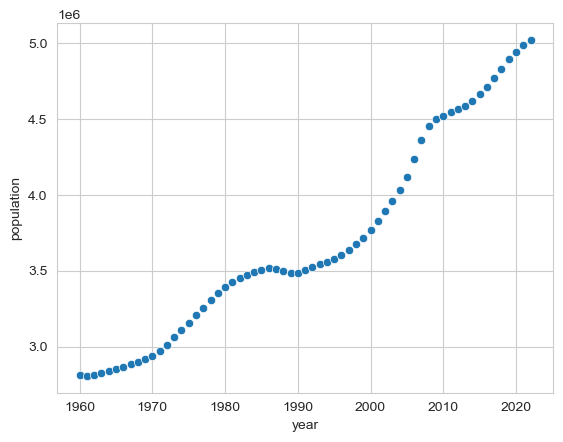

In [58]:
sns.scatterplot(data=df_new, x='year', y='population')

<Axes: >

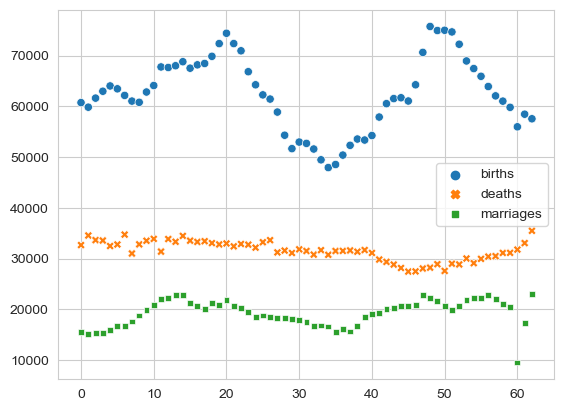

In [59]:
sns.scatterplot(data=df_new.iloc[:,1:4])

<Axes: >

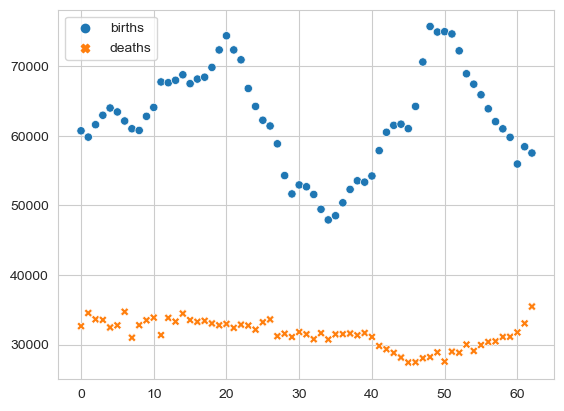

In [60]:
sns.scatterplot(data=df_new.iloc[:,1:3])

<Axes: >

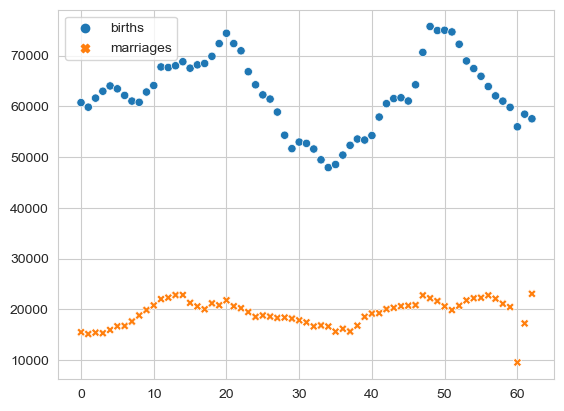

In [61]:
sns.scatterplot(data=df_new.iloc[:,[1,3]])

<Axes: xlabel='year', ylabel='births'>

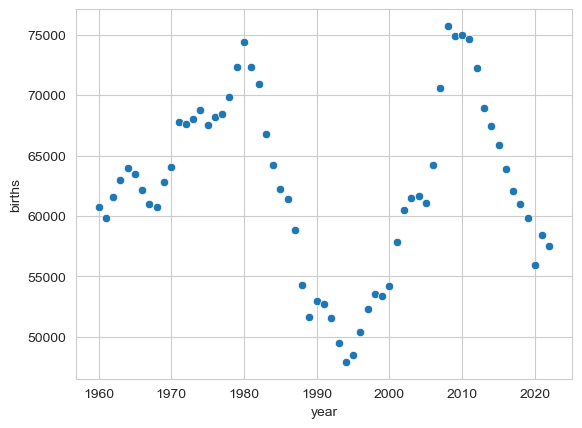

In [62]:
sns.scatterplot(data=df_new, x='year', y='births')

<Axes: xlabel='year', ylabel='deaths'>

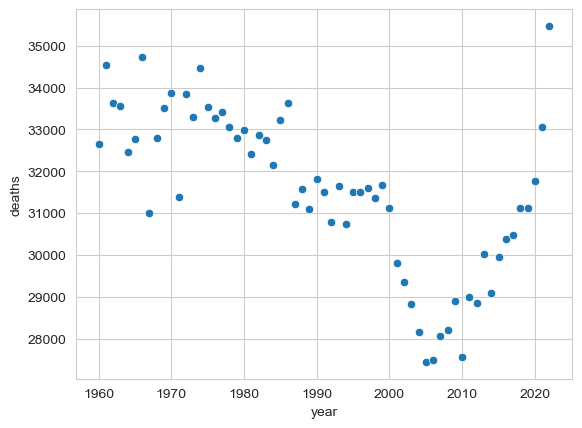

In [63]:
sns.scatterplot(data=df_new, x='year', y='deaths')

<Axes: xlabel='year', ylabel='marriages'>

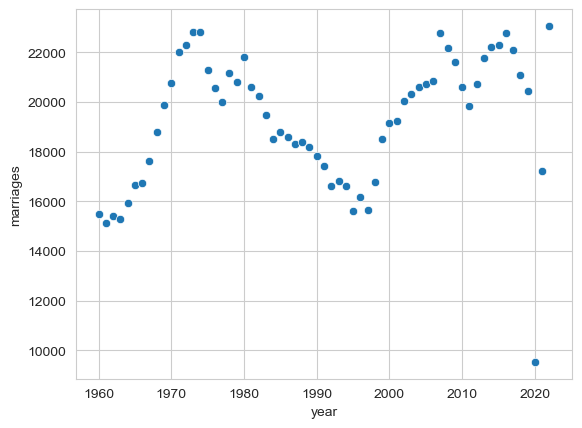

In [64]:
sns.scatterplot(data=df_new, x='year', y='marriages')

### Machine Learning models

In [65]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score


X = df_new.iloc[:,0:4]
y = df_new['population']

In [66]:
X.shape, y.shape

((63, 4), (63,))

###  Random Forest Regressor:
To perform a Hyperparameter tuning we can use the Grid Search library to help us iterate multiple values of parameters through the Machine Learning model.

In [67]:
from sklearn.model_selection import GridSearchCV

In [68]:
tuning_grid = {
    'n_estimators': [10, 20, 30, 40, 50],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [3, 5, 7, 9],
    'min_samples_leaf': [1, 2, 3, 4],
    'max_leaf_nodes': [3, 4, 5, 6, 7, 8, 9]  
}

In [69]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X, y, test_size=0.10, random_state=4)
X1_train.shape, X1_test.shape, y1_train.shape, y1_test.shape

((56, 4), (7, 4), (56,), (7,))

In [70]:
grid_search1 = GridSearchCV(RandomForestRegressor(), 
                           param_grid=tuning_grid, scoring='r2') 
grid_search1.fit(X1_train, y1_train) 
print(grid_search1.best_estimator_) 

RandomForestRegressor(max_depth=3, max_features=None, max_leaf_nodes=8,
                      min_samples_leaf=2, n_estimators=30)


In [71]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X, y, test_size=0.20, random_state=4)
X2_train.shape, X2_test.shape, y2_train.shape, y2_test.shape

((50, 4), (13, 4), (50,), (13,))

In [72]:
grid_search2 = GridSearchCV(RandomForestRegressor(), 
                           param_grid=tuning_grid, scoring='r2') 
grid_search2.fit(X2_train, y2_train) 
print(grid_search2.best_estimator_) 

RandomForestRegressor(max_depth=9, max_features=None, max_leaf_nodes=8,
                      n_estimators=50)


In [73]:
X3_train, X3_test, y3_train, y3_test = train_test_split(X, y, test_size=0.30, random_state=4)
X3_train.shape, X3_test.shape, y3_train.shape, y3_test.shape

((44, 4), (19, 4), (44,), (19,))

In [74]:
grid_search3 = GridSearchCV(RandomForestRegressor(), 
                           param_grid=tuning_grid, scoring='r2') 
grid_search3.fit(X3_train, y3_train) 
print(grid_search3.best_estimator_) 

RandomForestRegressor(max_depth=5, max_features=None, max_leaf_nodes=9,
                      n_estimators=40)


In [75]:
print('Best Hyperparameters (90% training):',grid_search1.best_params_)
print('Best Score (90% training):',grid_search1.best_score_)
print('Best Hyperparameters (80% training):',grid_search2.best_params_)
print('Best Score (80% training):',grid_search2.best_score_)
print('Best Hyperparameters (70% training):',grid_search3.best_params_)
print('Best Score (70% training):',grid_search3.best_score_)

Best Hyperparameters (90% training): {'max_depth': 3, 'max_features': None, 'max_leaf_nodes': 8, 'min_samples_leaf': 2, 'n_estimators': 30}
Best Score (90% training): 0.9884136441330742
Best Hyperparameters (80% training): {'max_depth': 9, 'max_features': None, 'max_leaf_nodes': 8, 'min_samples_leaf': 1, 'n_estimators': 50}
Best Score (80% training): 0.9842569641149181
Best Hyperparameters (70% training): {'max_depth': 5, 'max_features': None, 'max_leaf_nodes': 9, 'min_samples_leaf': 1, 'n_estimators': 40}
Best Score (70% training): 0.9899161442848969


### R2 scores comparison (Training v Testing):

In [76]:
RF1 = RandomForestRegressor(max_depth=5, max_features=None, max_leaf_nodes=8, min_samples_leaf=1, n_estimators=20)
RF1.fit(X1_train, y1_train)
train1_pred = RF1.predict(X1_train)
y1_pred = RF1.predict(X1_test)
train1_result = r2_score(y1_train, train1_pred)
test1_result = r2_score(y1_test, y1_pred)
print('r2_score result (training)(90% training):',train1_result)
print('r2_score result (testing)(90% training):',test1_result)

r2_score result (training)(90% training): 0.997160177980436
r2_score result (testing)(90% training): 0.9972906688320045


In [77]:
RF2 = RandomForestRegressor(max_depth=5, max_features=None, max_leaf_nodes=8, min_samples_leaf=1, n_estimators=50)
RF2.fit(X2_train, y2_train)
train2_pred = RF2.predict(X2_train)
y2_pred = RF2.predict(X2_test)
train2_result = r2_score(y2_train, train2_pred)
test2_result = r2_score(y2_test, y2_pred)
print('r2_score result (training)(80% training):',train2_result)
print('r2_score result (testing)(80% training):',test2_result)

r2_score result (training)(80% training): 0.997100540355632
r2_score result (testing)(80% training): 0.9958398398338045


In [78]:
RF3 = RandomForestRegressor(max_depth=7, max_features=None, max_leaf_nodes=9, min_samples_leaf=1, n_estimators=30)
RF3.fit(X3_train, y3_train)
train3_pred = RF3.predict(X3_train)
y3_pred = RF3.predict(X3_test)
train3_result = r2_score(y3_train, train3_pred)
test3_result = r2_score(y3_test, y3_pred)
print('r2_score result (training)(70% training):',train3_result)
print('r2_score result (testing)(70% training):',test3_result)

r2_score result (training)(70% training): 0.99492287461079
r2_score result (testing)(70% training): 0.9934000910938847


### Feature importances:

90% training

In [79]:
features1 = pd.DataFrame(RF1.feature_importances_).T
features1.columns = X.columns
features1

,year,births,deaths,marriages
0,0.980269,0.011416,0.006515,0.0018


80% training

In [80]:
features2 = pd.DataFrame(RF2.feature_importances_).T
features2.columns = X.columns
features2

,year,births,deaths,marriages
0,0.974052,0.011483,0.010739,0.003726


70% training

In [81]:
features3 = pd.DataFrame(RF3.feature_importances_).T
features3.columns = X.columns
features3

,year,births,deaths,marriages
0,0.92446,0.007207,0.064182,0.004151


In our RandomForestRegressor 3, which has a 70% of training data, we can observe that the 'deaths' feature has a higher importance than in the other 2 models, this is particularly relevant knowing that since 2005-2006 (in our 'years-deaths' plot) the number of deaths in Ireland are rising and reaching all time highs in recent years.

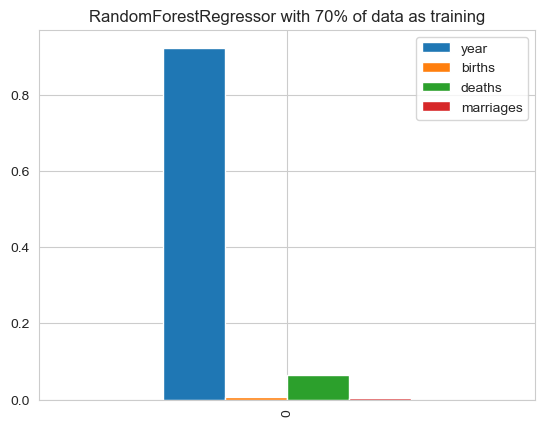

In [82]:
features3.plot(kind='bar', title='RandomForestRegressor with 70% of data as training');

### Second approach

Following our initial understanding of our data and feature importance using the Random Forest Regressor algorithm, we will compare multiple machine learning models.

In this new approach, considering that our data type is time series, using our target feature (Population) we will make sure that our data is stationary before training our models.

Time Series is a way of stydying the characteristics of the response variable concerning time as the independent variable. To estimate the target variable in forecasting, we use the time variable as the reference point (Pandian, 2021).

In [83]:
# Function to plot and check our time series data
def plot_time_series(xt, nlag = 30, fig_size = (10,8)):
    if not isinstance(xt, pd.Series):
        xt = pd.Series(xt)
    plt.figure(figsize = fig_size)
    layout = (2,2)

    ax_xt = plt.subplot2grid(layout, (0,0), colspan = 2) # It will take 2 column spaces
    ax_acf = plt.subplot2grid(layout, (1,0))
    ax_pacf = plt.subplot2grid(layout, (1,1))

    xt.plot(ax = ax_xt)
    ax_xt.set_title('Time Series', fontdict = {'fontsize':18})
    plot_acf(xt, lags = 50, ax = ax_acf)
    plot_pacf(xt, lags = 50, ax = ax_pacf)
    plt.tight_layout() # Adjust the padding between and around subplots
    return None

In [84]:
df_new

,year,births,deaths,marriages,population
0,1960,60730,32658,15494,2811075
1,1961,59826,34548,15140,2807012
2,1962,61611,33643,15409,2813072
3,1963,62966,33558,15298,2824097
4,1964,64008,32473,15941,2837439
...,...,...,...,...,...
58,2018,61016,31116,21101,4834506
59,2019,59796,31134,20452,4896021
60,2020,55959,31765,9533,4946123
61,2021,58443,33055,17230,4986525


In [86]:
# We will put our 'year' feature as index to perform the time series analysis
df_new['year'] = pd.to_datetime(df_new['year'], format = '%Y')
df_new.index = df_new['year']
df_new.drop('year', axis = 1, inplace = True) # Since we now have our index based on the year, we do not longer need our 'year' feature

In [87]:
df_new

,births,deaths,marriages,population
year,,,,
1960-01-01,60730,32658,15494,2811075
1961-01-01,59826,34548,15140,2807012
1962-01-01,61611,33643,15409,2813072
1963-01-01,62966,33558,15298,2824097
1964-01-01,64008,32473,15941,2837439
...,...,...,...,...
2018-01-01,61016,31116,21101,4834506
2019-01-01,59796,31134,20452,4896021
2020-01-01,55959,31765,9533,4946123
